In [1]:
import neurokit as nk
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import warnings
import re
import os
import json

reading the acqknowledge file returns both the dataframe and a sampling rate.

In [2]:
acq_df, samp_rate = nk.bio.bio_data.read_acqknowledge("sub-2002/ses-day1pre/sub-2002_ses-day1pre_0002.acq")

Neuropsydia error: get_creation_date(): We're probably on Linux. No easy way to get creation dates here, so we'll settle for when its content was last modified.


In [ ]:
# see what the dataframe looks like
acq_df.head()

In [ ]:
# use a bash command to look inside the correct txt file
!head -n 5 sub-2002/ses-day1pre/sub-2002_ses-day1pre_task-rest_run-2_physio.txt

In [ ]:
# since there is no header in the txt file, we need to supply our own header
# in the pandas dataframe
acq_df.columns

In [ ]:
txt_df = pd.read_csv("sub-2002/ses-day1pre/sub-2002_ses-day1pre_task-rest_run-2_physio.txt",
            header=None,
            index_col=False,
            names=acq_df.columns,
            sep="\t")
txt_df.head()

In [ ]:
s = acq_df['PPG100C']

In [ ]:
acq_df['PPG100C'][1]

In [ ]:
s[1]

In [ ]:
txt_df['PPG100C'][1]

In [ ]:
# the columns are not identical
acq_df['PPG100C'].reset_index(drop=True).equals(txt_df['PPG100C'])

In [ ]:
a = acq_df['PPG100C'].reset_index(drop=True)

In [ ]:
t = txt_df['PPG100C']

In [ ]:
# when we compare a column by asking if they are "close enough"
np.all(np.isclose(a, t))

## Explore Atrain data

In [ ]:
acq_df, samp_rate = nk.bio.bio_data.read_acqknowledge("sub-GEA161/ses-activepre/acute161_0002.acq")

In [ ]:
acq_df.head()

In [ ]:
# use a bash command to look inside the correct txt file
# cannot read because of line endings CRLF instead of LF
!head -n 5 sub-GEA161/ses-activepre/NBack1_1.txt


In [ ]:
txt_df = pd.read_csv("sub-GEA161/ses-activepre/Rest1_1.txt",
            header=None,
            index_col=False,
            names=acq_df.columns,
            sep="\t")
txt_df.head()

In [ ]:
np.any(txt_df.iloc[0,:].isnull())

In [ ]:
txt_df = pd.read_csv("sub-GEA161/ses-activepre/Rest1_1.txt",
            skiprows=14,
            header=None,
            index_col=0,
            names=acq_df.columns,
            sep="\t").reset_index(drop=True)
txt_df.drop([0], axis=0, inplace=True)

txt_df.head()

In [ ]:
atrain_file = "sub-GEA161/ses-activepre/Rest1_1.txt"
atrain_ptrn = re.compile(r"(?P<sub_id>sub-[A-Za-z0-9]+)"
                         r"/(?P<ses_id>ses-[A-Za-z0-9]+)"
                         r"/(?P<task_id>[A-Za-z]+)[1-9]_"
                         r"(?P<run_id>[0-9]).txt")

extend_file = "sub-2002/ses-day1pre/sub-2002_ses-day1pre_task-rest_physio.txt"
extend_ptrn = re.compile(r".*/"
                         r"(?P<sub_id>sub-[A-Za-z0-9]+)"
                         r"(_(?P<ses_id>ses-[A-Za-z0-9]+))"
                         r"(_(?P<task_id>task-[A-Za-z0-9]+))"
                         r"(_(?P<run_id>run-[0-9]+))?"
                         r"_physio.txt")
atrain_mch = atrain_ptrn.match(atrain_file)
extend_mch = extend_ptrn.match(extend_file)

In [ ]:
display(atrain_mch.groupdict())
display(extend_mch.groupdict())

In [ ]:
# function to return dictionary mapping acq files to txt files

def match_acq_txt(acqs, txts, outdir):
    # pattern for matching atrain files
    atrain_ptrn = re.compile(r".*/"
                             r"(?P<sub_id>sub-[A-Za-z0-9]+)"
                             r"/(?P<ses_id>ses-[A-Za-z0-9]+)"
                             r"/(?P<task_id>[A-Za-z]+)[1-9]"
                             r"(_(?P<run_id>[0-9]))?.txt")
    extend_ptrn = re.compile(r".*/"
                             r"(?P<sub_id>sub-[A-Za-z0-9]+)"
                             r"(_(?P<ses_id>ses-[A-Za-z0-9]+))"
                             r"(_(?P<task_id>task-[A-Za-z0-9]+))"
                             r"(_(?P<run_id>run-[0-9]+))?"
                             r"(_physio)?.txt")
    group_msr = []
    acq_txt_dict = {}
    group_tsv = os.path.join(outdir, "group.tsv")
    no_acq_matches = []
    for acq in acqs:
        # read the acqknowledge file
        acq_df, samp_rate = nk.bio.bio_data.read_acqknowledge(acq)
        # too small to be useful
        if acq_df.shape[0] < 200:
                continue

        for txt in txts:
            if os.path.dirname(acq) != os.path.dirname(txt):
                continue
            # read the txt file
            txt_df = pd.read_csv(txt,
            header=None,
            index_col=False,
            names=acq_df.columns,
            sep="\t")
            
            # if any of the first columns contains nans
            if np.any(txt_df.iloc[0,:].isnull()):
                txt_df = pd.read_csv(txt,
                    skiprows=14,
                    header=None,
                    index_col=0,
                    names=acq_df.columns,
                    sep="\t")
                txt_df.reset_index(drop=True, inplace=True)
                txt_df.drop([0], axis=0, inplace=True)
            # select this column for comparisons
            a = acq_df['PPG100C'].reset_index(drop=True)[:200]
            t = txt_df['PPG100C'][:200]
            
            if np.all(np.isclose(a, t)):
                if acq_df.shape[0] < 2000:
                    import pdb; pdb.set_trace()
                acq_txt_dict[acq] = txt
                txts.remove(txt)
                break
        
        if acq not in acq_txt_dict.keys():
            no_acq_matches.append(acq)
            continue
        
        # base filename
        ref_txt = acq_txt_dict[acq]
        atrain_mch = atrain_ptrn.match(ref_txt)
        extend_mch = extend_ptrn.match(ref_txt)
        
        if atrain_mch:
            fdict = atrain_mch.groupdict()
            # make task lowercase
            fdict['task_id'] = fdict['task_id'].lower()
            if fdict['run_id'] == 3 or fdict['run_id'] == 4:
                fdict['run_id'] = fdict['run_id'] - 2
        elif extend_mch:
            fdict = extend_mch.groupdict()
            if fdict["run_id"]:
                fdict["run_id"] = fdict["run_id"].lstrip("run-") 
        else:
            import pdb; pdb.set_trace()
            raise("FileName did not match either atrain or extend pattern")

        fdict["sub_id"] = fdict["sub_id"].lstrip("sub-")
        fdict["ses_id"] = fdict["ses_id"].lstrip("ses-")
        fdict["task_id"] = fdict["task_id"].lstrip("task-")

        if not fdict["run_id"]:
            tmplt = os.path.join(outdir,
                                 "sub-{sub_id}",
                                 "ses-{ses_id}",
                                 "sub-{sub_id}_ses-{ses_id}_task-{task_id}_{typ}.{ext}")
        elif fdict["run_id"]:
            tmplt = os.path.join(outdir,
                                 "sub-{sub_id}",
                                 "ses-{ses_id}",
                                 "sub-{sub_id}_ses-{ses_id}_task-{task_id}_run-{run_id}_{typ}.{ext}")
        fig_file = tmplt.format(**fdict, typ="qa", ext="png")
        data_file = tmplt.format(**fdict, typ="physio", ext="tsv")
        sum_file = tmplt.format(**fdict, typ="summary", ext="json")
        
        if not os.path.isfile(fig_file) or not os.path.isfile(data_file) or not os.path.isfile(sum_file):
            # make sure directory exists to place files
            os.makedirs(os.path.dirname(fig_file), exist_ok=True)

            # where the Scanner Trigger is 0 initiates a slice acquition in the scanner
            start = acq_df["Scanner Trigger"].where(acq_df["Scanner Trigger"]==0.0).first_valid_index()
            end = acq_df["Scanner Trigger"].where(acq_df["Scanner Trigger"]==0.0).last_valid_index()
            if start is None or end is None:
                warnings.warn("Scan Trigger Not Recognized, keeping all rows")
                acq_cut_df = acq_df
            else:
                acq_cut_df = acq_df.iloc[(acq_df.index >= start) & (acq_df.index <= end)]

            try:
                res = nk.bio_eda.eda_process(acq_df['GSR100C'], filter_type='butter',
                                             band="bandpass", order=1, frequency=(0.05, 1),
                                             sampling_rate=200)
            except IndexError:
                import pdb; pdb.set_trace()

            out_df = res['df']

            out_df.to_csv(data_file, sep="\t")

            out_df.plot(y=["EDA_Raw", "EDA_Filtered"], title=fig_file)
            plt.savefig(fig_file)
            plt.clf()

            sub_dict = {
                "participant_id": fdict["sub_id"],
                "session_id": fdict["ses_id"],
                "task_id": fdict["task_id"],
                "run_id": fdict.get("run_id"),
                "EDA_mean": out_df["EDA_Filtered"].mean(),
                "EDA_median": out_df["EDA_Filtered"].median(),
                "EDA_std": out_df["EDA_Filtered"].std()
            }

            with open(sum_file, 'w') as outfile:  
                json.dump(sub_dict, outfile)

        else:
            with open(sum_file) as json_file:  
                sub_dict = json.load(json_file)
        
        group_msr.append(sub_dict)
    
        
    group_df = pd.DataFrame(group_msr)
    group_df.to_csv(group_tsv, sep="\t")
    no_txt_matches = txts
    
    return acq_txt_dict, no_acq_matches, no_txt_matches, group_df
            

In [ ]:
acqs = glob("./sub-*/**/*.acq")

txts = glob("./sub-*/**/*.txt")

outdir = './qa'

In [ ]:
def testr(mystr):
    raise(RuntimeWarning)
    print(mystr)

In [ ]:
testr("this")

In [ ]:
txts

In [ ]:
acq_txt_dict, no_acq_matches, no_txt_matches, group_df = match_acq_txt(acqs, txts, outdir)

In [ ]:
group_df

In [ ]:
no_txt_matches

In [ ]:
acq_txt_dict

In [15]:
res = nk.bio_eda.eda_process(acq_df['GSR100C'], filter_type='butter', band="bandpass", order=1, frequency=(0.05, 1), sampling_rate=200)

In [16]:
res['df']

,EDA_Raw,EDA_Filtered,EDA_Phasic,EDA_Tonic,SCR_Onsets,SCR_Recoveries,SCR_Peaks
0,0.585939,4.846610e-04,0.000000,1.607851,NaN,NaN,NaN
1,0.585939,4.830499e-04,0.000000,1.607353,NaN,NaN,NaN
2,0.588991,4.813617e-04,0.518065,1.606854,NaN,NaN,NaN
3,0.585939,4.795947e-04,0.515360,1.606354,NaN,NaN,NaN
4,0.585939,4.777476e-04,0.512672,1.605853,NaN,NaN,NaN
5,0.585939,4.758188e-04,0.510000,1.605351,NaN,NaN,NaN
6,0.588991,4.738071e-04,0.507346,1.604848,NaN,NaN,NaN
7,0.588991,4.717110e-04,0.504707,1.604344,NaN,NaN,NaN
8,0.582887,4.695296e-04,0.502085,1.603839,NaN,NaN,NaN
9,0.584413,4.672616e-04,0.499480,1.603333,NaN,NaN,NaN


In [17]:
out = res['df']


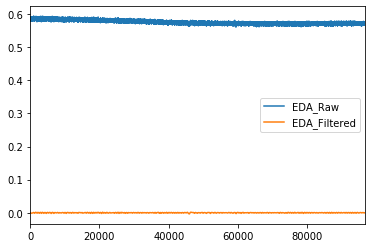

In [18]:
out.plot(y=["EDA_Raw", "EDA_Filtered"])
plt.savefig('test.png')

In [ ]:
plt.plot(res['df'][["EDA_Raw", "EDA_Filtered"]])

In [ ]:
start = acq_df["Scanner Trigger"].where(acq_df["Scanner Trigger"]==0.0).first_valid_index()
end = acq_df["Scanner Trigger"].where(acq_df["Scanner Trigger"]==0.0).last_valid_index()

In [ ]:
acq_cut_df = acq_df.iloc[(acq_df.index >= start) & (acq_df.index <= end)]
display(acq_cut_df.head())
display(acq_cut_df.tail())

In [ ]:
res['df']["EDA_Filtered"].mean()

In [ ]:
tmplt = "{a}_{b}_{c}"
mdic = {'a': 'this', 'b': 'is'}

In [ ]:
tmplt.format(**mdic, c="sparta")

In [ ]:
thg = None

In [ ]:
thg.replace('sub-', "")

In [ ]:
for x in range(10):
    for y in ["a", "b", "c", "d"]:
        if y == "b":
            continue
        else:
            print(str(x), y)